In [20]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from keras.models import Sequential
from keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
import keras
from keras.optimizers import RMSprop
import matplotlib as mpl

In [21]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('noAnno_train_8_nucleotide_array.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('noAnno_train_8_nucleotide_labels.npy')
y_train = y_flt_train.astype(int)
print(y_train)

dict_test = np.load('noAnno_test_8_nucleotide_array.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('noAnno_test_8_nucleotide_labels.npy')
y_test = y_flt_test.astype(int)
print(y_test)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

[1 0 0 ... 1 1 0]
[0 1 0 ... 1 0 1]
Training features shape: (7968, 8, 4)
Test features shape: (3984, 8, 4)
Training labels shape: (7968,)
Test labels shape: (3984,)


In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [23]:
neg, pos = np.bincount(y_train)+np.bincount(y_test)
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)

Examples:
    Total: 11952
    Positive: 6855 (57.35% of total)

Training labels shape: (7968,)
Test labels shape: (3984,)
Training features shape: (7968, 8, 4)
Test features shape: (3984, 8, 4)


In [24]:
def make_model1(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        # The input shape is 8x4
        # This is the first convolution
        Conv1D(16, 3, strides=1, activation='relu', padding='same',
               input_shape=(8, 4),
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Conv1D(32, 3, strides=1, activation='relu', padding='same',
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        #  neuron hidden layer
        Dense(128, activation='relu', bias_initializer=output_bias),  # 8/2(maxpooling)=4, 32*4 = 128
        Dropout(0.2),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
        Dense(1, activation='sigmoid')  # Sigmoid for binary question.
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # optimizer=RMSprop(lr=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [25]:
def make_model2(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        # The input shape is 8x4
        # This is the first convolution
        Conv1D(64, 3, strides=1, activation='relu', padding='same',
               input_shape=(8, 4),
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Conv1D(32, 3, strides=1, activation='relu', padding='same',
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        #  neuron hidden layer
        Dense(128, activation='relu', bias_initializer=output_bias),  # 8/2(maxpooling)=4, 32*4 = 128
        Dropout(0.2),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
        Dense(1, activation='sigmoid')  # Sigmoid for binary question.
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # optimizer=RMSprop(lr=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [46]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [49]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-GNRA Detected (True Negatives): ', cm[0][0])
  print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
  print('GNRA Missed (False Negatives): ', cm[1][0])
  print('GNRA Detected (True Positives): ', cm[1][1])
  print('Total GNRA: ', np.sum(cm[1]))

In [57]:
def plot_metrics(history1, history2):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history1.epoch, history1.history[metric], color=colors[0], label='Conf1_Train')
    plt.plot(history1.epoch, history1.history['val_' + metric],
             color=colors[0], linestyle="--", label='Conf1_Test')
    plt.plot(history2.epoch, history2.history[metric], color=colors[1], label='Conf2_Train')
    plt.plot(history2.epoch, history2.history['val_' + metric],
             color=colors[1], linestyle="--", label='Conf2_Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [61]:
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)

  plt.rcParams['font.size'] = '16'
  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate = fp/(fp+tn)')
  plt.ylabel('True positives rate = tp/(tp+fn)')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [30]:
def plot_prc(name, labels, predictions, **kwargs):  #precision = tp / (tp + fp), recall = tp / (tp + fn)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.rcParams['font.size'] = '9'
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall = TP / (TP + FP)')
    plt.ylabel('Precision = TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [67]:
# retrain with class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.17
Weight for class 1: 0.87


In [33]:
weighted_model1 = make_model1()
#weighted_model.load_weights(initial_weights)

weighted_history1 = weighted_model1.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 1.17, 1: 0.87})

Epoch 1/20


2024-01-09 19:01:11.678869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


497/498 [============================>.] - ETA: 0s - loss: 0.3874 - tp: 4568.0000 - fp: 1231.0000 - tn: 2778.0000 - fn: 751.0000 - accuracy: 0.7875 - precision: 0.7877 - recall: 0.8588 - auc: 0.8394 - prc: 0.8361

2024-01-09 19:01:18.123603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


498/498 [==============================] - 9s 16ms/step - loss: 0.3870 - tp: 4579.0000 - fp: 1231.0000 - tn: 2782.0000 - fn: 752.0000 - accuracy: 0.7878 - precision: 0.7881 - recall: 0.8589 - auc: 0.8396 - prc: 0.8366 - val_loss: 0.1709 - val_tp: 2137.0000 - val_fp: 102.0000 - val_tn: 1599.0000 - val_fn: 146.0000 - val_accuracy: 0.9378 - val_precision: 0.9544 - val_recall: 0.9360 - val_auc: 0.9832 - val_prc: 0.9851
Epoch 2/20
498/498 [==============================] - 8s 15ms/step - loss: 0.1855 - tp: 4297.0000 - fp: 238.0000 - tn: 3158.0000 - fn: 275.0000 - accuracy: 0.9356 - precision: 0.9475 - recall: 0.9399 - auc: 0.9778 - prc: 0.9803 - val_loss: 0.1248 - val_tp: 2186.0000 - val_fp: 41.0000 - val_tn: 1660.0000 - val_fn: 97.0000 - val_accuracy: 0.9654 - val_precision: 0.9816 - val_recall: 0.9575 - val_auc: 0.9907 - val_prc: 0.9903
Epoch 3/20
498/498 [==============================] - 8s 15ms/step - loss: 0.1518 - tp: 4363.0000 - fp: 161.0000 - tn: 3235.0000 - fn: 209.0000 - accuracy

In [34]:
weighted_model2 = make_model2()
#weighted_model.load_weights(initial_weights)

weighted_history2 = weighted_model2.fit(
    x_train,
    y_train, 
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 1.17, 1: 0.87})

Epoch 1/20


2024-01-09 19:03:57.587030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


498/498 [==============================] - ETA: 0s - loss: 0.2561 - tp: 6279.0000 - fp: 405.0000 - tn: 4692.0000 - fn: 576.0000 - accuracy: 0.9179 - precision: 0.9394 - recall: 0.9160 - auc: 0.9775 - prc: 0.9815

2024-01-09 19:04:04.419580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


498/498 [==============================] - 9s 17ms/step - loss: 0.2561 - tp: 6279.0000 - fp: 405.0000 - tn: 4692.0000 - fn: 576.0000 - accuracy: 0.9179 - precision: 0.9394 - recall: 0.9160 - auc: 0.9775 - prc: 0.9815 - val_loss: 0.0930 - val_tp: 2239.0000 - val_fp: 50.0000 - val_tn: 1651.0000 - val_fn: 44.0000 - val_accuracy: 0.9764 - val_precision: 0.9782 - val_recall: 0.9807 - val_auc: 0.9925 - val_prc: 0.9921
Epoch 2/20
498/498 [==============================] - 9s 18ms/step - loss: 0.1222 - tp: 4409.0000 - fp: 131.0000 - tn: 3265.0000 - fn: 163.0000 - accuracy: 0.9631 - precision: 0.9711 - recall: 0.9643 - auc: 0.9882 - prc: 0.9881 - val_loss: 0.0802 - val_tp: 2255.0000 - val_fp: 56.0000 - val_tn: 1645.0000 - val_fn: 28.0000 - val_accuracy: 0.9789 - val_precision: 0.9758 - val_recall: 0.9877 - val_auc: 0.9958 - val_prc: 0.9955
Epoch 3/20
498/498 [==============================] - 8s 16ms/step - loss: 0.0984 - tp: 4437.0000 - fp: 109.0000 - tn: 3287.0000 - fn: 135.0000 - accuracy: 0

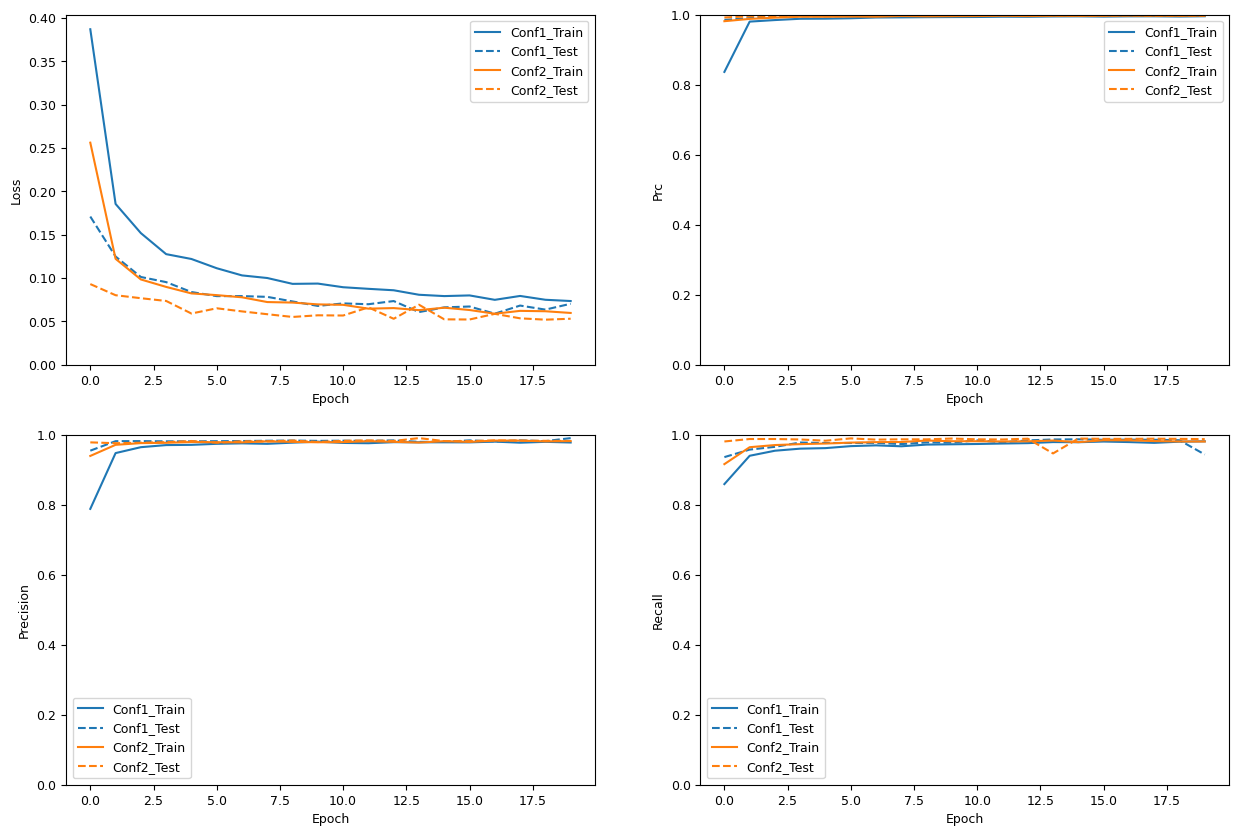

In [58]:
plot_metrics(weighted_history1, weighted_history2)

In [36]:
train_predictions_weighted1 = weighted_model1.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted1 = weighted_model1.predict(x_test, batch_size=BATCH_SIZE)

 49/498 [=>............................] - ETA: 0s

2024-01-09 19:06:35.003385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


249/249 [==============================] - 0s 2ms/step


In [37]:
train_predictions_weighted2 = weighted_model2.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted2 = weighted_model2.predict(x_test, batch_size=BATCH_SIZE)

 94/498 [====>.........................] - ETA: 0s

2024-01-09 19:06:36.644704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


249/249 [==============================] - 0s 2ms/step


loss :  0.07030712068080902
tp :  2154.0
fp :  21.0
tn :  1680.0
fn :  129.0
accuracy :  0.9623494744300842
precision :  0.9903448224067688
recall :  0.9434953927993774
auc :  0.9967817664146423
prc :  0.9968774318695068

[[1680   21]
 [ 129 2154]]
-----
Non-GNRA Detected (True Negatives):  1680
Non-GNRA Incorrectly Detected (False Positives):  21
GNRA Missed (False Negatives):  129
GNRA Detected (True Positives):  2154
Total GNRA:  2283


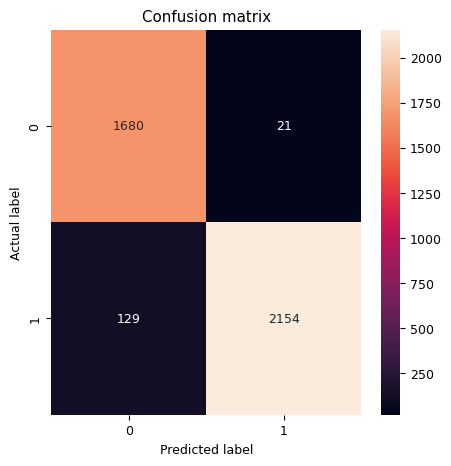

In [50]:
# Results of test data set. 
weighted_results1 = weighted_model1.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model1.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted1)

loss :  0.07030712068080902
tp :  2154.0
fp :  21.0
tn :  1680.0
fn :  129.0
accuracy :  0.9623494744300842
precision :  0.9903448224067688
recall :  0.9434953927993774
auc :  0.9967817664146423
prc :  0.9968774318695068

Non-GNRA Detected (True Negatives):  1660
Non-GNRA Incorrectly Detected (False Positives):  41
GNRA Missed (False Negatives):  29
GNRA Detected (True Positives):  2254
Total GNRA:  2283


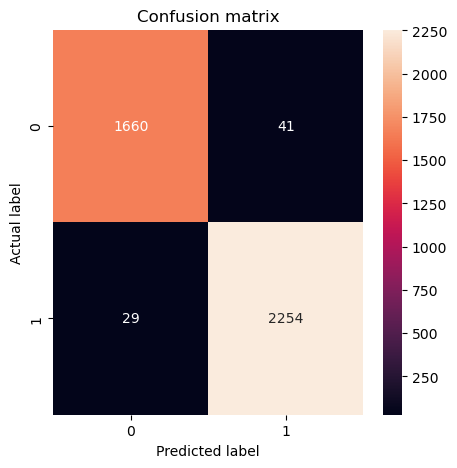

In [39]:
# Results of test data set. 
weighted_results2 = weighted_model2.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model2.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted2)

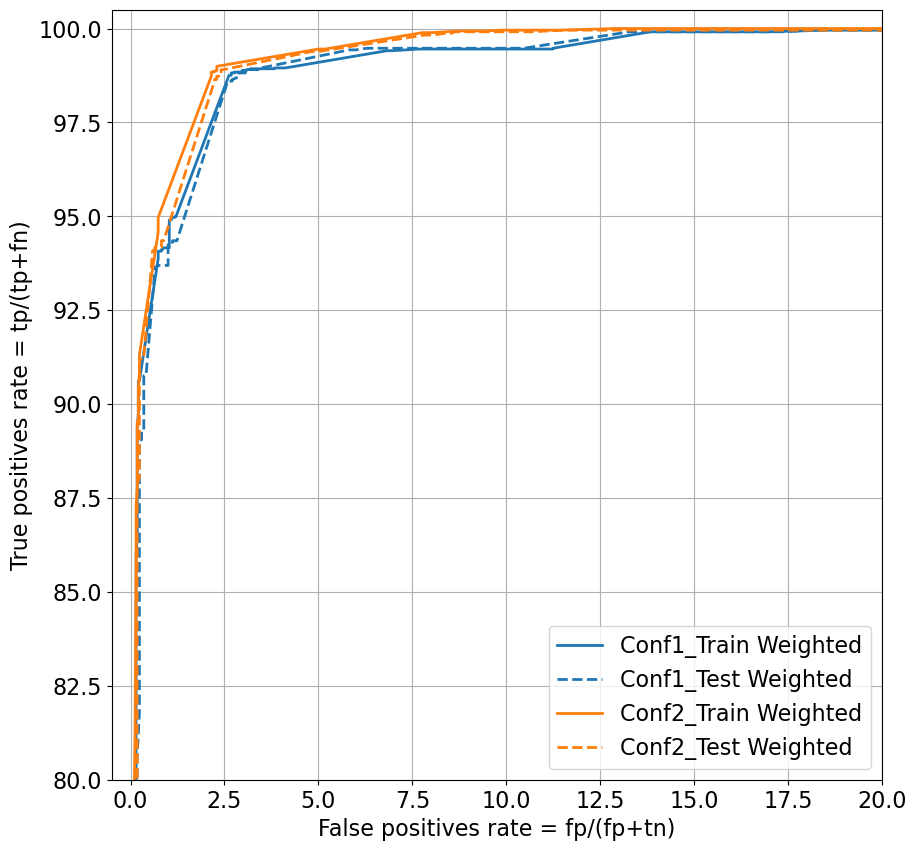

In [62]:
plot_roc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_roc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_roc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_roc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

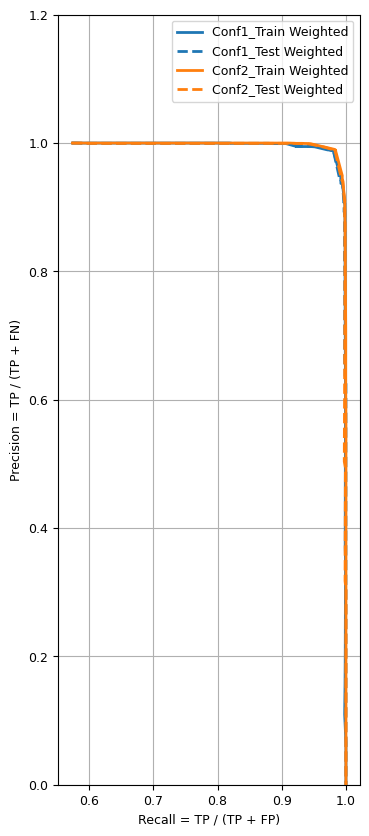

In [41]:
plot_prc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_prc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_prc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_prc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')
# plt.xlim([0, 1.2])
plt.ylim([0, 1.2])

plt.legend(loc='upper right');